# Auto calibration 4x8

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rtde_control, rtde_receive
import tikzplotlib

ROBOT_HOST = "10.42.0.162" # IP address of the robot

rtde_r = rtde_receive.RTDEReceiveInterface(ROBOT_HOST)
rtde_c = rtde_control.RTDEControlInterface(ROBOT_HOST)


In [3]:
from tools.controller import *
controller = CalibrationController(rtde_r, rtde_c)

controller.get_sensor_pose()

# Victor
# transform = np.array([[1, 0, 0],
#                       [0, 1, 0],
#                       [0, 0, 1]])
transform = np.array([[np.sqrt(2)/2,-np.sqrt(2)/2, 0],
               [-np.sqrt(2)/2, -np.sqrt(2)/2, 0],
               [0, 0, 1]])         
                      
controller.set_transform(transform)

start_point = controller.get_sensor_pose()
# start_point = [-0.2409340763694389, -0.1887068514791564, -0.14776195701575625, -1.9045541303624176, -2.4983988443139533, 8.590224947108232e-05]

# controller.move_absolute(start_point, 0.01)

top_point_z = start_point[2]
print(start_point, top_point_z)

[0.289044209330182, 0.013705227012610083, -0.1384899666042378, 2.542140458693223, 1.8456957062262291, 1.979281984194092e-05] -0.1384899666042378


In [4]:
controller.move_absolute(start_point)

# Top point
controller.move_absolute(start_point[0:3])
top_point_z = controller.find_contact_point([0, 0, -1], 0.005)[2] 
controller.move_absolute(start_point[0:3])

depth = top_point_z - start_point[2] - 0.004

# Double X points
controller.move_relative([0.05, 0.003, 0])
controller.move_relative([0.0, 0, depth], 0.01)
x_pose_1 = controller.find_contact_point([-1, 0, 0], 0.005)[0:2]
controller.move_relative([0.005, 0, 0])

controller.move_relative([0, -0.003 * 2, 0])
x_pose_2 = controller.find_contact_point([-1, 0, 0], 0.005)[0:2]
controller.move_relative([0.005, 0, -depth])
controller.move_absolute(start_point[0:3])

# Extra x point other side
controller.move_absolute(start_point[0:3])
controller.move_relative([-0.05, 0, 0])
controller.move_relative([0.0, 0, depth], 0.01)
x_pose_3 = controller.find_contact_point([1, 0, 0], 0.005)[0:2]
controller.move_relative([-0.005, 0, -depth])
controller.move_absolute(start_point[0:3])


# Single Y point
controller.move_relative([0, 0.02, 0])
controller.move_relative([0.0, 0, depth], 0.01)
y_pose_1 = controller.find_contact_point([0, -1, 0], 0.005)[0:2]
controller.move_relative([0, 0.005, -depth])
controller.move_absolute(start_point[0:3])

# second Y point
controller.move_relative([0, -0.02, 0])
controller.move_relative([0.0, 0, depth], 0.01)
y_pose_2 = controller.find_contact_point([0, 1, 0], 0.005)[0:2]
controller.move_relative([0, -0.005, -depth])
controller.move_absolute(start_point[0:3])

poses = np.array([x_pose_1, x_pose_2, x_pose_3, y_pose_1, y_pose_2])

In [5]:
poses = np.array([x_pose_1, x_pose_2, x_pose_3, y_pose_1, y_pose_2])

In [6]:
print(poses)

[[0.30634564 0.01661632]
 [0.3061765  0.01055515]
 [0.25806891 0.01372049]
 [0.28898899 0.0317356 ]
 [0.28912365 0.00469047]]


Width x: 0.04436349736462737, width y: 0.023045465189296493


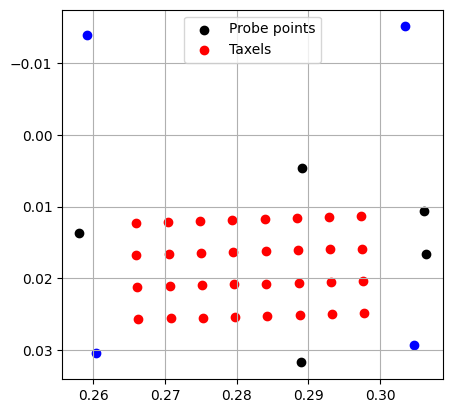

In [7]:
from tools.helpers import *
import matplotlib.pyplot as plt
import matplotlib

tool_width = 0.004 / 2 # We want radius
pitch = 0.0045
# 7mm for my design, 6mm for remko design
offset = (0.09 + pitch / 2, 0.0025 + pitch / 2) # Offset should be the position of the first sensor, NOT the corner of the silicon
sensor_grid_size = (8, 4)
nr_of_subpoints = 0

grid_size = (sensor_grid_size[0] + (sensor_grid_size[0] - 1) * nr_of_subpoints, sensor_grid_size[1] + (sensor_grid_size[1] - 1) * nr_of_subpoints )

width_x = np.linalg.norm(np.array(x_pose_1) - np.array(x_pose_3)) - 2 * tool_width
width_y = np.linalg.norm(np.array(y_pose_1) - np.array(y_pose_2)) - 2 * tool_width

print(f"Width x: {width_x}, width y: {width_y}")

offset = ( (width_x - pitch * (sensor_grid_size[0] - 1)) / 2, offset[1])

offset = ( (width_x - pitch * (sensor_grid_size[0] - 1)) / 2, (width_y - pitch * (sensor_grid_size[1] - 1)) / 2)

offset = (offset[0] - 0.0004, offset[1] - 0.00015)


corners, deltas = get_square_corners(x_pose_1, x_pose_2, y_pose_1, width_x, width_x, tool_width)

# Corners index 0 and 3 are the bottom points
# So now we need to calculate the grid based on those

plt.scatter(poses[:, 0], poses[:, 1], c='black', label='Probe points')
plt.scatter(corners[:, 0], corners[:, 1], c='blue')

# plt.plot([corners[-1, 0], corners[0, 0]], [corners[-1, 1], corners[0,1]], c='blue', label='Fingertip ')
# plt.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1,1]], c='blue')
# plt.plot([corners[1, 0], corners[2, 0]], [corners[1, 1], corners[2,1]], c='blue')

grid = calculate_grid_on_square(corners, offset, grid_size, pitch / (nr_of_subpoints + 1))

# Add startpoint index 2,3,4,5 to grid
actual_grid = np.zeros((grid_size[1], grid_size[0], 6))
actual_grid[:, :, 2:] = start_point[2:]
actual_grid[:, :, :2] = grid

grid = actual_grid

# matplotlib.rcParams["figure.dpi"] = 1200

plt.grid()
plt.scatter(grid[:, :, 0], grid[:, :, 1], c='red', label='Taxels')

plt.xlabel
plt.legend(loc='upper center')


plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()

# plt.savefig("./result.png", bbox_inches='tight', format='png', dpi=1000)

In [9]:
# Check if ok
import time
z_clearance = 0.001
duration = 5

controller.move_absolute(start_point[0:3])

for row in grid:
    for point in row:
        
        # Move above point
        controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
        
        time.sleep(duration / (grid_size[0] * grid_size[1]))
  
controller.move_absolute(start_point[0:3])

[0.2890445049769556,
 0.013745731255339615,
 -0.13850661825568783,
 2.5421259782296906,
 1.843719105445854,
 0.0011086929129145021]

In [11]:
import time
from tools.measuring import MeasuringInterface
measuring_interface = MeasuringInterface(controller)

In [14]:
measuring_interface.start_measuring("tmp")
time.sleep(1)
measuring_interface.stop_measuring()

In [15]:
def ascending_sine_wave(time, frequency, max_amplitude, phase_shift = 0, shifted=True):
    max_time = np.max(time)
    time_adjusted = time - max_time
    if shifted:
        y_values = max_amplitude / max_time / 2 * time * (np.sin(2 * np.pi * frequency * time_adjusted - np.pi/2 + phase_shift) + 1)
    else:
        y_values = max_amplitude / max_time * time * np.sin(2 * np.pi * frequency * time_adjusted - np.pi/2 + phase_shift)
        
    return y_values[::-1]



In [16]:
from time import sleep

def apply_general_force(input_curves, sample_rate=200):
  
  limits = [0.1, 0.1, 0.1]
  
  points_x = input_curves[0]
  points_y = input_curves[1]  
  points_z = input_curves[2]
  
  assert len(points_x) == len(points_y) == len(points_z)
  
  for i in range(len(input_curves[0])):
    
    f_x = points_x[i]
    f_y = points_y[i]
    f_z = points_z[i]
    
    controller.force_mode([1, 1, 1], [f_x, f_y, f_z], limits)
    sleep(1 / sample_rate)

  

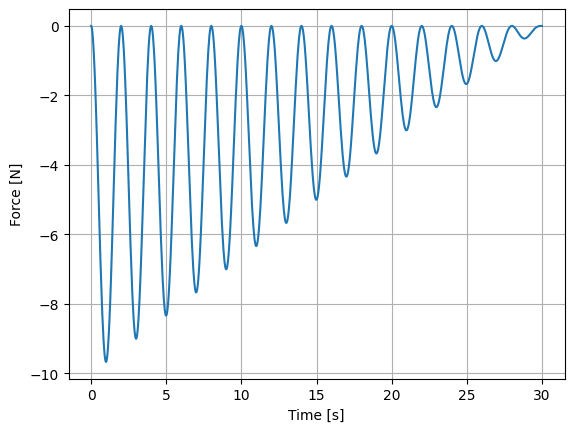

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def generate_forces(frequency, max_force, length, sample_rate=200):
  force_rate = abs(max_force) / length

  time = np.linspace(0, abs(max_force) / force_rate, int(abs(max_force) / force_rate * sample_rate))  # Time values from 0 to 2 seconds

  normal_force_values = ascending_sine_wave(time, frequency, max_force, 0, True)
  
  return normal_force_values

for freq in [0.5]:
  normal_force_values = generate_forces(freq, -10, 30) 
  time = np.linspace(0, 30, len(normal_force_values))
  plt.plot(time,normal_force_values)
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")

import tikzplotlib
tikzplotlib.clean_figure()
tikzplotlib.save("force_curve.tex")

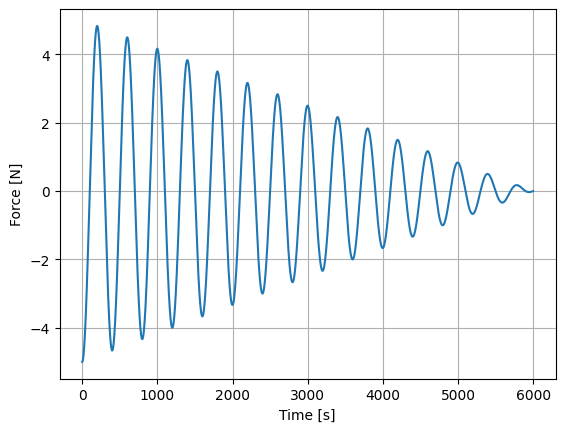

In [18]:
import numpy as np
def generate_xy_forces(frequency, max_force, length, sample_rate=200):
  force_rate = max_force / length

  time = np.linspace(0, abs(max_force) / force_rate, int(abs(max_force) / force_rate * sample_rate))  # Time values from 0 to 2 seconds

  x_force_values = ascending_sine_wave(time, frequency, max_force, 0, False)
  y_force_values = ascending_sine_wave(time, frequency, max_force, np.pi/2, False)
  
  return x_force_values, y_force_values

x_force_values, y_force_values = generate_xy_forces(0.5, 5, 30)

plt.plot(x_force_values)
# plt.plot(y_force_values)
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.savefig("./result.png", bbox_inches='tight', format='png', dpi=1000)

In [24]:
controller.move_absolute(start_point)
rtde_c.zeroFtSensor()

measuring_interface.start_measuring("taxel28_test")
sleep(3)

for freq in [0.5, 3]:

  normal_force_values = generate_forces(freq, -10, 30)
  xy_force = np.zeros_like(normal_force_values)  

  controller.move_absolute(start_point)
  rtde_c.zeroFtSensor()
  sleep(1)
  
  controller.move_relative([0,0,-0.005], 0.005)

  sleep(1)

  apply_general_force([xy_force, xy_force, normal_force_values], 200)
  
  rtde_c.forceModeStop()
  controller.move_absolute(start_point)
  
  sleep(3)

sleep(3)
measuring_interface.stop_measuring()
rtde_c.forceModeStop()
controller.move_absolute(start_point)

[-0.24095737727448496,
 -0.18870368695887668,
 -0.1495514128932386,
 -1.904574922807175,
 -2.49833306927183,
 0.00014257650281837252]

In [132]:
def calibrate_taxel(taxel_id, point, clearance, sample_rate=200):
  
  controller.move_absolute(point)
  rtde_c.zeroFtSensor()

  measuring_interface.start_measuring(f"taxel{taxel_id}")
  sleep(3)      
  
  for freq in [0.5, 3]:
    
    #
    # Z component
    #

    max_force = -10
    length = 30
    force_rate = abs(max_force) / length
    
    time = np.linspace(0, abs(max_force) / force_rate, int(abs(max_force) / force_rate * sample_rate))  # Time values from 0 to 2 seconds
    normal_force_values = ascending_sine_wave(time, freq, max_force, 0, True)
    
    xy_force = np.zeros_like(normal_force_values)

    controller.move_absolute(point)
    rtde_c.zeroFtSensor()
    sleep(1)
    
    controller.move_relative([0,0,-1 * clearance], 0.005)

    sleep(1)

    apply_general_force([xy_force, xy_force, normal_force_values], 200)
    
    rtde_c.forceModeStop()
    controller.move_absolute(point)
    
    sleep(3)
    
    #
    # X component
    #
    
    max_force = 5
    length = 30
    force_rate = abs(max_force) / length
    
    time = np.linspace(0, abs(max_force) / force_rate, int(abs(max_force) / force_rate * sample_rate))  # Time values from 0 to 2 seconds
    x_force = ascending_sine_wave(time, freq, max_force, 0, False)
    
    y_force = np.zeros_like(x_force)
    normal_force = np.ones_like(x_force) * -5
    
    # Zero prefix for the first 5 seconds
    x_force = np.concatenate([np.zeros(int(5 * sample_rate)), x_force])
    y_force = np.concatenate([np.zeros(int(5 * sample_rate)), y_force])
    normal_force = np.concatenate([np.ones(int(5 * sample_rate)) * -5, normal_force])

    controller.move_absolute(point)
    rtde_c.zeroFtSensor()
    sleep(1)
    
    controller.move_relative([0,0,-0.003], 0.005)

    sleep(1)

    apply_general_force([x_force, y_force, normal_force], 200)
    
    rtde_c.forceModeStop()
    controller.move_absolute(point)
    
    sleep(3)
    
    #
    # Y component
    #
    
    controller.move_absolute(point)
    rtde_c.zeroFtSensor()
    sleep(1)
    
    controller.move_relative([0,0,-1 * clearance], 0.005)

    sleep(1)

    apply_general_force([y_force, x_force, normal_force], 200)
    
    rtde_c.forceModeStop()
    controller.move_absolute(point)
    
    sleep(3)
    
    #
    # XY component (validation)
    #
    
    x_force = ascending_sine_wave(time, freq, max_force, 0, False)
    y_force = ascending_sine_wave(time, freq, max_force, np.pi/2, False)
    
    # Zero prefix for the first 5 seconds
    x_force = np.concatenate([np.zeros(int(5 * sample_rate)), x_force])
    y_force = np.concatenate([np.zeros(int(5 * sample_rate)), y_force])    
    
    controller.move_absolute(point)
    rtde_c.zeroFtSensor()
    sleep(1)
    
    controller.move_relative([0,0,-1 * clearance], 0.005)

    sleep(1)

    apply_general_force([y_force, x_force, normal_force], 200)
    
    rtde_c.forceModeStop()
    controller.move_absolute(point)
    
    sleep(3)
    
    
    
      
      

  measuring_interface.stop_measuring()
  rtde_c.forceModeStop()
  controller.move_absolute(start_point)

In [133]:
clearance = 0.9 * (start_point[2] - top_point_z)
print(clearance)

0.0034203192938440873


In [135]:
# ids = [28, 24, 20, 16, 12, 8, 4, 0] + [29, 25, 21, 17, 13, 9, 5, 1] + [30, 26, 22, 18, 14, 10, 6, 2] + [31, 27, 23, 19, 15, 11, 7, 3]
ids = [31, 27, 23, 19, 15, 11, 7, 3, 30, 26, 22, 18, 14, 10, 6, 2, 29, 25, 21, 17, 13, 9, 5, 1, 28, 24, 20, 16, 12, 8, 4, 0]

actual_skip = [28, 24, 20, 16,        31, 27, 23, 19, 15, 11, 7, 3,        30, 26, 22, 18,         29, 25, 21, 17, 13, 9, 5, 1, 12, 8, 4, 0]
skip = actual_skip

controller.move_absolute(start_point)
  
for i, id in enumerate(ids):
  
  print(f"Calibrating taxel {id}")
  
  if id in skip:
    print("Skipping taxel", id)
    continue
  
  # Move to grid position
  controller.move_absolute(grid[i // 8][i % 8])
  controller.move_relative([0,0,-1 * clearance], 0.005)
  
  try:
      
    result = input("Confirm that the taxel is in the correct position")
    
    if result != "y":
      raise Exception("Taxel not in correct position")
    
    controller.move_relative([0,0,clearance], 0.005)
    

    calibrate_taxel(id, grid[i // 8][i % 8], clearance)
  except Exception as e:
    print(e)
    print("Error on taxel", id)
    
    measuring_interface.stop_measuring()
    rtde_c.forceModeStop()
    controller.move_relative([0,0,0.01], 0.005)
    controller.move_absolute(start_point)
    break

Calibrating taxel 31
Skipping taxel 31
Calibrating taxel 27
Skipping taxel 27
Calibrating taxel 23
Skipping taxel 23
Calibrating taxel 19
Skipping taxel 19
Calibrating taxel 15
Skipping taxel 15
Calibrating taxel 11
Skipping taxel 11
Calibrating taxel 7
Skipping taxel 7
Calibrating taxel 3
Skipping taxel 3
Calibrating taxel 30
Skipping taxel 30
Calibrating taxel 26
Skipping taxel 26
Calibrating taxel 22
Skipping taxel 22
Calibrating taxel 18
Skipping taxel 18
Calibrating taxel 14
Calibrating taxel 10
Calibrating taxel 6
Calibrating taxel 2
Calibrating taxel 29
Skipping taxel 29
Calibrating taxel 25
Skipping taxel 25
Calibrating taxel 21
Skipping taxel 21
Calibrating taxel 17
Skipping taxel 17
Calibrating taxel 13
Skipping taxel 13
Calibrating taxel 9
Skipping taxel 9
Calibrating taxel 5
Skipping taxel 5
Calibrating taxel 1
Skipping taxel 1
Calibrating taxel 28
Skipping taxel 28
Calibrating taxel 24
Skipping taxel 24
Calibrating taxel 20
Skipping taxel 20
Calibrating taxel 16
Skipping t

In [136]:
measuring_interface.stop_measuring()
rtde_c.forceModeStop()
controller.move_absolute(start_point)

[-0.21350899637567372,
 -0.17940607203090658,
 -0.14850435283316607,
 -1.9067212317245672,
 -2.4966980317261562,
 0.00021040746109735845]

Reconnecting...


RTDEControlInterface: Could not receive data from robot...
RTDEControlInterface Exception: End of file
RTDEControlInterface: Robot is disconnected, reconnecting...
RTDEControlInterface Exception: Timeout connecting to UR dashboard server.
RTDEReceiveInterface Exception: End of file
